In [1]:
#Zainstalowanie odpowiednich pakietów
import sys
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#Zaimportowanie odpowiednich pakietów
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import re

In [3]:
#Wczytanie danych z pliku CSV
df = pd.read_csv('inpatientCharges.csv')

In [4]:
#Sprawdzenie, czy plik wczytał się poprawnie
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


In [5]:
#Sprawdzenie, ile stanów zawartych jest w bazie 
df['Provider State'].nunique()

51

In [6]:
#Sprawdzanie typów danych w kolumnach; próba rozwiązania problemu ze stringami na przykładzie jednej kolumny
df[' Average Covered Charges '].dtype
type(df[' Average Covered Charges '][0])
df[' Average Covered Charges '].map(type).unique()
df[' Average Covered Charges '] = df[' Average Covered Charges '].apply(lambda x: x.split('$')[1])
df[' Average Covered Charges '].dtype
df[' Average Covered Charges '] = df[' Average Covered Charges '].astype(float)

In [7]:
df[df[' Average Covered Charges '].isna()==True].shape #Nie będzie problemu z NaN, bo nie ma takich wartości

(0, 12)

In [8]:
#Zaaplikowanie rozwiązania do wszystkich kolumn wymagających konwersji
df[' Total Discharges '] = df[' Total Discharges '].astype(float)
df[df[' Total Discharges '].isna()==True].shape

(0, 12)

In [9]:
df[' Average Total Payments '] = df[' Average Total Payments '].apply(lambda x: x.split('$')[1])
df[' Average Total Payments '] = df[' Average Total Payments '].astype(float)
df[df[' Average Total Payments '].isna()==True].shape

(0, 12)

In [10]:
df['Average Medicare Payments'] = df['Average Medicare Payments'].apply(lambda x: x.split('$')[1])
df['Average Medicare Payments'] = df['Average Medicare Payments'].astype(float)
df[df['Average Medicare Payments'].isna()==True].shape

(0, 12)

In [ ]:
#Stworzenie nowych zmiennych, które będą pokazyały poszczególne części kosztów jako procent całości
df['Medicare Payments as Percentage'] = df['Average Medicare Payments'] / df[' Average Total Payments '] * 100
df['Actual Payments as Percentage'] = df[' Average Total Payments '] / df[' Average Covered Charges '] * 100
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Medicare Payments as Percentage,Actual Payments as Percentage,Unpaid Charges,Unpaid Charges as Percentage,Unpaid Charges,Unpaid Charges as Percentage
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,82.456848,17.526402,27185.83,82.473598,27185.83,82.473598
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71,85.989629,38.247604,9344.28,61.752396,9344.28,61.752396
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79,81.947212,14.469905,32125.42,85.530095,32125.42,85.530095
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25.0,13998.28,5417.56,4129.16,76.218076,38.701612,8580.72,61.298388,8580.72,61.298388
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18.0,31633.27,5658.33,4851.44,85.739785,17.887275,25974.94,82.112725,25974.94,82.112725


In [127]:
# stworzenie unikalnej listy chorób
choroby = list()
choroby = df['DRG Definition'].unique()

In [128]:
#przypisanie poszczególnej chorobie w liście ilości jej wystąpień w bazie 
liczba_chorob = df['DRG Definition'].value_counts().to_dict()

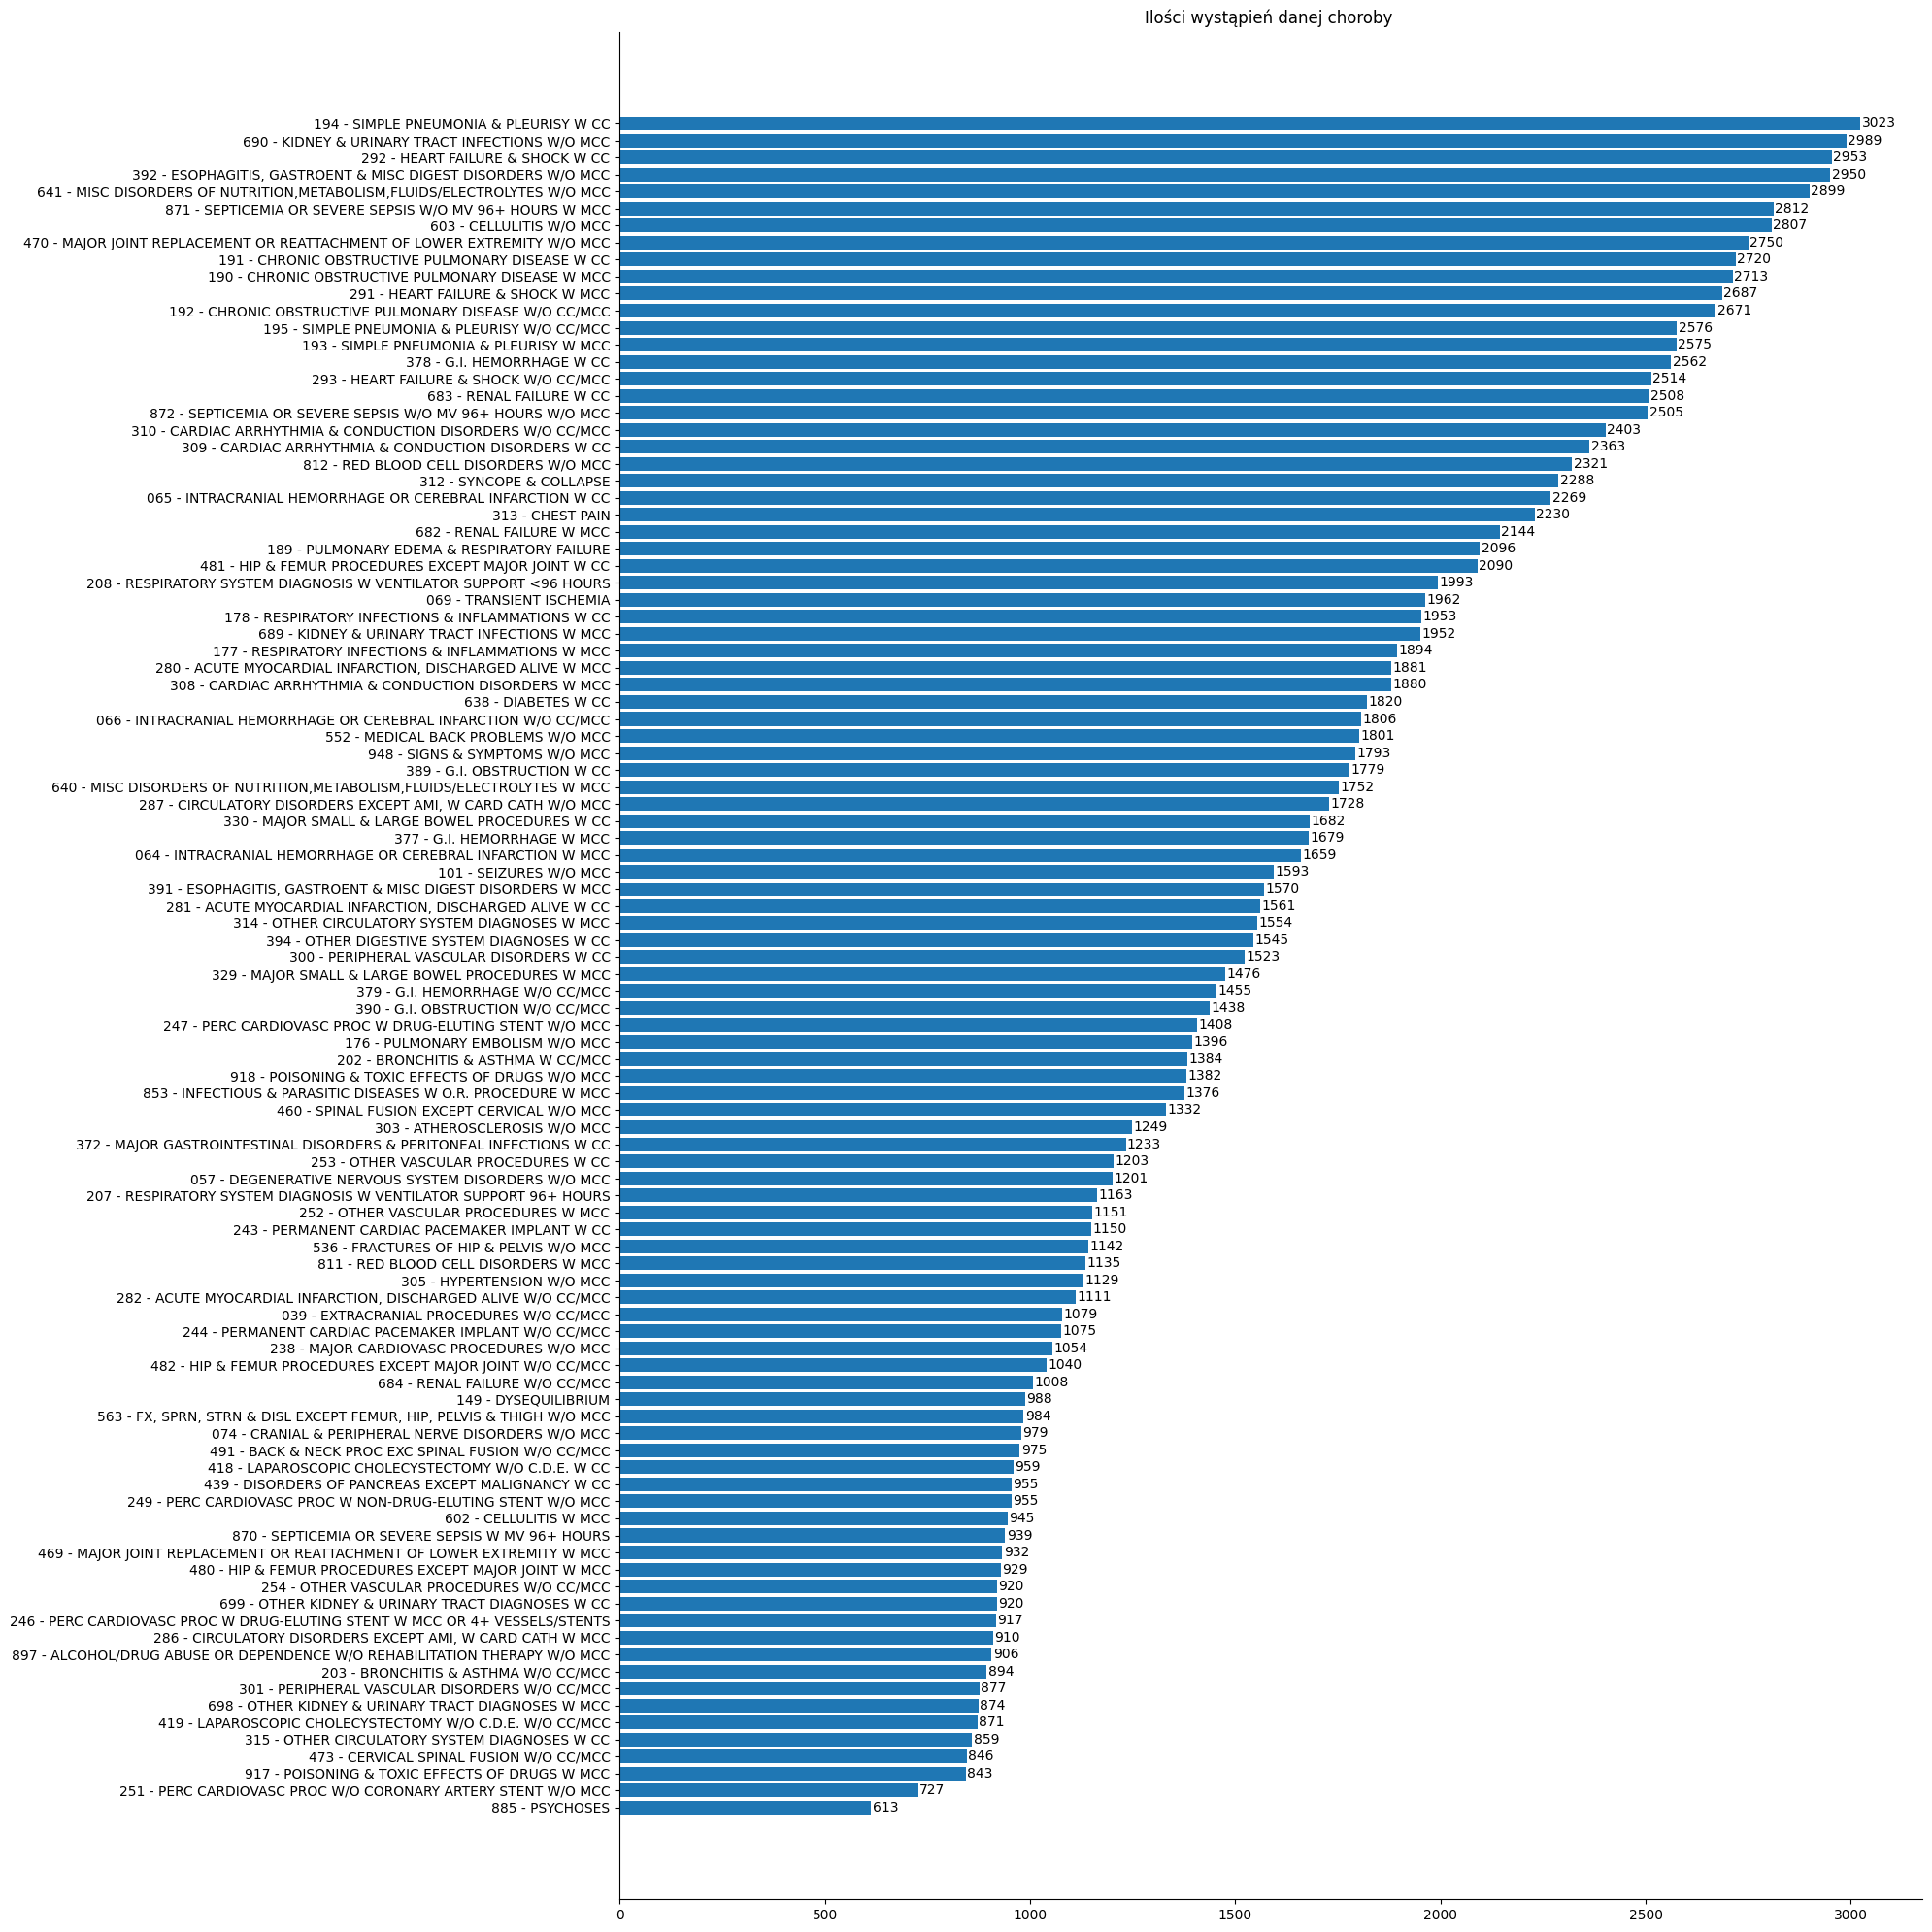

In [129]:
# wykres słupkowy ("Z tytułu czego pacjenci są najczęściej przyjmowani? + Ile ludzi na nie choruje?")
#sortowanie malejąco słownika
posortowana_liczba_chorob = sorted(
    liczba_chorob.items(),
    key=lambda item: item[1],
    reverse=False  # Dodajemy ten argument
)
posortowana_liczba_chorob = dict(posortowana_liczba_chorob)

#tworzenie wykresu
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()

bars = ax.barh(posortowana_liczba_chorob.keys(), posortowana_liczba_chorob.values())
ax.bar_label(bars, padding=1, fontsize=10) # dodajemy etykiety

ax.set_title('Ilości wystąpień danej choroby ')
ax.spines['top'].set_visible(False)    # usuwa górne obramowanie
ax.spines['right'].set_visible(False)  # usuwa prawe obramowanie
plt.tight_layout()
#plt.savefig('wykres1.png')
plt.show()

In [ ]:
# Najczęściej występowane choroby:
# 194 - SIMPLE PNEUMONIA & PLEURISY W CC
# 690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC
# 292 - HEART FAILURE & SHOCK W CC

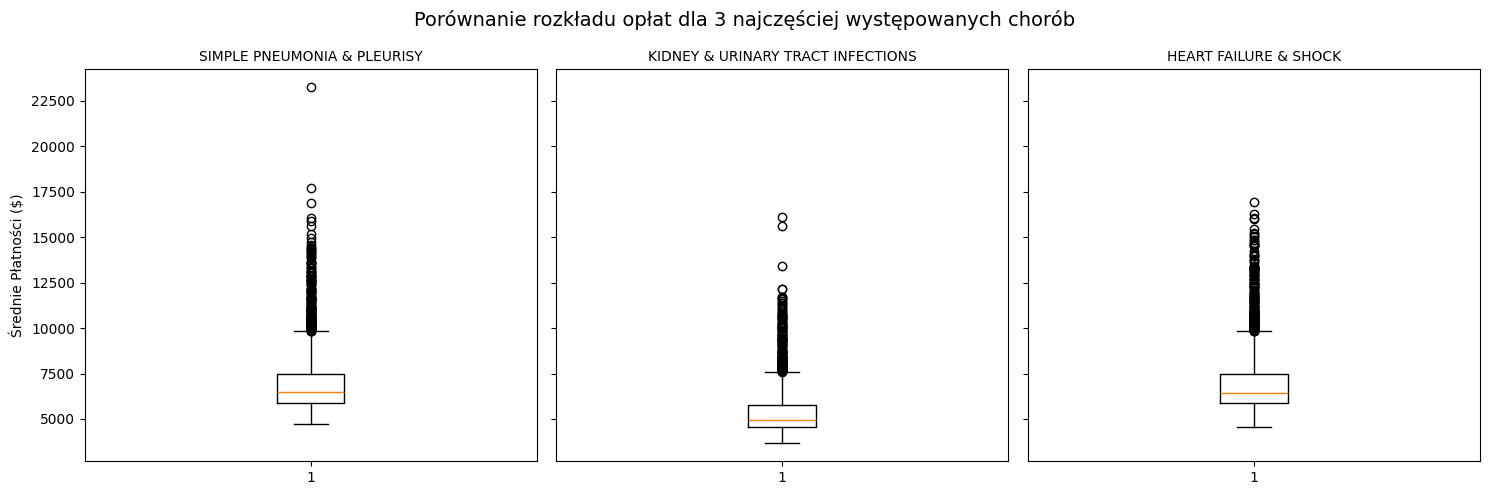

In [130]:
# wiersze dla tej konkretnej choroby 
dane_dla_choroby1 = df[df['DRG Definition'] == "194 - SIMPLE PNEUMONIA & PLEURISY W CC"]
dane_dla_choroby2 = df[df['DRG Definition'] == "690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC"]
dane_dla_choroby3 = df[df['DRG Definition'] == "292 - HEART FAILURE & SHOCK W CC"]

# konkretna kolumna liczbowa do analizy
wartosci_do_wykresu1 = list(dane_dla_choroby1[' Average Total Payments '])
wartosci_do_wykresu2 = list(dane_dla_choroby2[' Average Total Payments '])
wartosci_do_wykresu3 = list(dane_dla_choroby3[' Average Total Payments '])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

ax1.boxplot(wartosci_do_wykresu1)
ax1.set_title('SIMPLE PNEUMONIA & PLEURISY', fontsize=10)
ax1.set_ylabel("Średnie Płatności ($)")


ax2.boxplot(wartosci_do_wykresu2)
ax2.set_title('KIDNEY & URINARY TRACT INFECTIONS', fontsize=10)

ax3.boxplot(wartosci_do_wykresu3)
ax3.set_title('HEART FAILURE & SHOCK', fontsize=10)

fig.suptitle('Porównanie rozkładu opłat dla 3 najczęściej występowanych chorób', fontsize=14)

plt.tight_layout()
#plt.savefig('wykres2.png')
plt.show()

In [131]:
#Grupowanie danych według stanów; sprawdzenie, w których stanach procentowa wartość płatności Medicare jest najwyższa i najnisza
df_stany = (
    df.groupby('Provider State')['Medicare Payments as Percentage']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)
df_stany.head()

,Provider State,Medicare Payments as Percentage
0,MD,88.894265
1,CA,88.508425
2,DC,88.432002
3,VT,87.486097
4,MA,87.252527


In [132]:
df_stany.tail()

,Provider State,Medicare Payments as Percentage
46,NV,82.700268
47,NE,82.562020
48,VA,82.135302
49,AL,81.662175
50,UT,78.570904


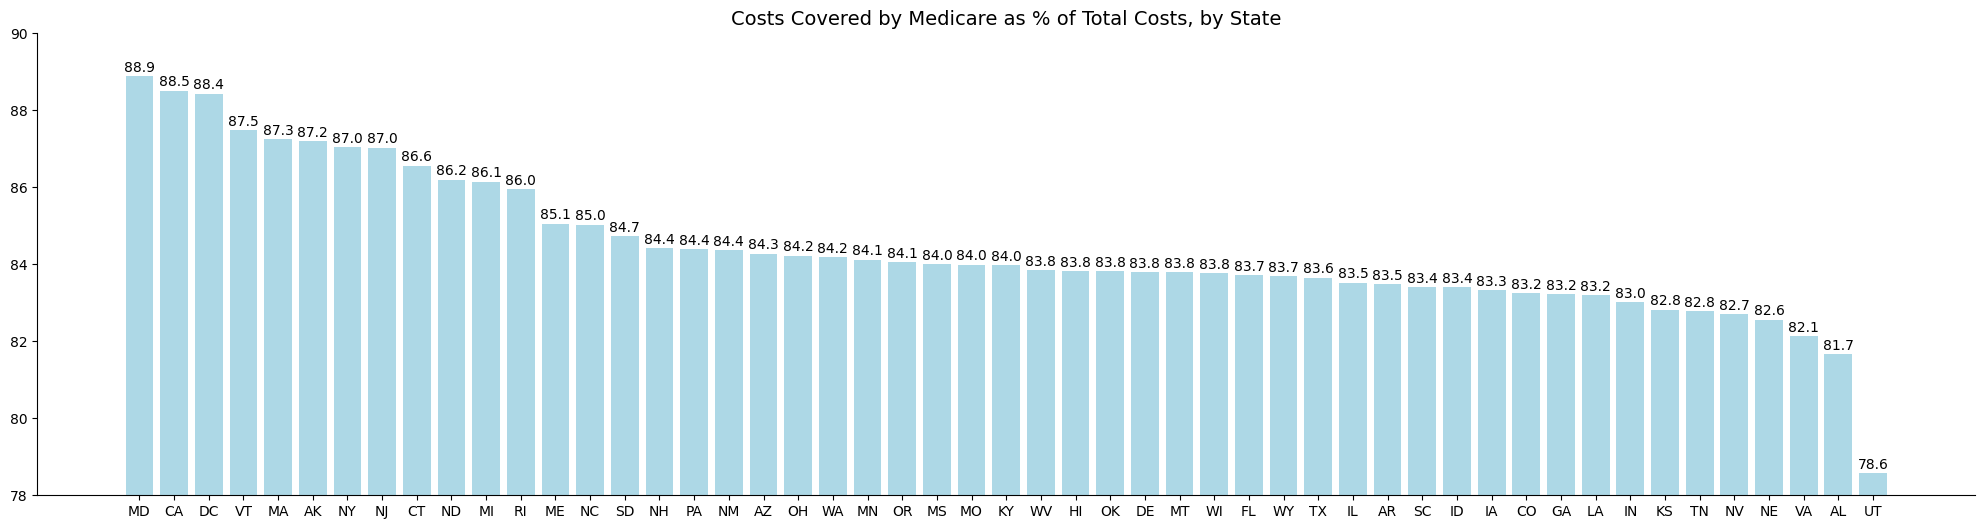

In [133]:
#Wizualizacja danych
fig = plt.figure(figsize =(25,6))
ax = plt.axes()
bars = ax.bar(df_stany['Provider State'], df_stany['Medicare Payments as Percentage'], color='lightblue', label='Medicare Payments as Percentage')
ax.bar_label(bars, fmt='%.1f', padding=1, fontsize=10)
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)  
ax.set_title('Costs Covered by Medicare as % of Total Costs, by State', fontsize=14)
ax.set_ylim(78,90)
plt.show()
#Okazuje sie, ze we wszystkich stanach wartosc pokrycia przez Medicare jest dosc podobna

In [134]:
#Sprawdzamy teraz po chorobach – dla jakich rachunek wystawiony przez szpital bedzie najbardziej zawyzony?
df.groupby('DRG Definition')['Actual Payments as Percentage'].mean().sort_values(ascending=False).tail(10)

DRG Definition
418 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. W CC                            29.087561
313 - CHEST PAIN                                                              29.063917
491 - BACK & NECK PROC EXC SPINAL FUSION W/O CC/MCC                           28.769755
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                                      28.283814
419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. W/O CC/MCC                      28.183032
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W MCC OR 4+ VESSELS/STENTS    28.168943
287 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W/O MCC                   26.375290
251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC                  25.453424
249 - PERC CARDIOVASC PROC W NON-DRUG-ELUTING STENT W/O MCC                   25.190290
247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC                       25.178392
Name: Actual Payments as Percentage, dtype: float64

In [135]:
#Omijamy choroby, sa podobne do siebie, wybieramy cztery konkretne
choroba5 = df[df['DRG Definition'] == "247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC"].copy()
choroba6 = df[df['DRG Definition'] == "287 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W/O MCC"].copy()
choroba7 = df[df['DRG Definition'] == "419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. W/O CC/MCC"].copy()
choroba8 = df[df['DRG Definition'] == "039 - EXTRACRANIAL PROCEDURES W/O CC/MCC"].copy()

choroba7


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Medicare Payments as Percentage,Actual Payments as Percentage,Unpaid Charges,Unpaid Charges as Percentage,Unpaid Charges,Unpaid Charges as Percentage
107181,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,15.0,26190.13,6612.40,5635.60,85.227754,25.247679,19577.73,74.752321,19577.73,74.752321
107182,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,16.0,22091.50,6373.50,5526.50,86.710599,28.850463,15718.00,71.149537,15718.00,71.149537
107183,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,19.0,34197.31,6497.73,5607.42,86.298138,19.000705,27699.58,80.999295,27699.58,80.999295
107184,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,AL - Birmingham,13.0,18194.00,6320.15,5009.46,79.261726,34.737551,11873.85,65.262449,11873.85,65.262449
107185,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,12.0,23279.33,7849.58,7008.58,89.286051,33.719098,15429.75,66.280902,15429.75,66.280902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108047,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,520089,MERITER HSPTL,202 S PARK ST,MADISON,WI,53715,WI - Madison,12.0,26277.75,8305.58,7464.58,89.874277,31.606892,17972.17,68.393108,17972.17,68.393108
108048,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,520097,ST MARYS HSPTL MED CTR,1726 SHAWANO AVE,GREEN BAY,WI,54303,WI - Green Bay,12.0,26792.41,6562.50,5627.16,85.747200,24.493877,20229.91,75.506123,20229.91,75.506123
108049,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,520103,COMMUNITY MEM HSPTL,W180 N8085 TOWN HALL RD,MENOMONEE FALLS,WI,53051,WI - Milwaukee,15.0,29175.26,7845.26,5671.00,72.285686,26.890112,21330.00,73.109888,21330.00,73.109888
108050,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,520139,AURORA WEST ALLIS MEDICAL CENTER,8901 W LINCOLN AVE,WEST ALLIS,WI,53227,WI - Milwaukee,12.0,35840.91,9665.83,5472.91,56.621211,26.968707,26175.08,73.031293,26175.08,73.031293


In [136]:
#Przeksztalcamy Average Covered Charges na liste wartosci do wykresu – chcemy zobaczyc, ile srednio szpitale charguja za leczenie tych chorob
#Czy srednia jest ogolnie wysoka, czy mamy duzo przeceniajacych outlierow?
wartosci_do_wykresu1 = list(choroba5[' Average Covered Charges '])
wartosci_do_wykresu2 = list(choroba6[' Average Covered Charges '])
wartosci_do_wykresu3 = list(choroba7[' Average Covered Charges '])
wartosci_do_wykresu4 = list(choroba8[' Average Covered Charges '])

In [137]:
print(wartosci_do_wykresu4)

[32963.07, 15131.85, 37560.37, 13998.28, 31633.27, 16920.79, 11977.13, 35841.09, 28523.39, 75233.38, 67327.92, 39607.28, 22862.23, 31110.85, 25411.33, 9234.51, 15895.85, 19721.16, 10710.88, 51343.75, 55219.31, 14948.15, 73846.21, 34805.13, 34803.81, 24474.75, 28571.61, 35968.5, 26294.52, 26771.78, 29967.8, 27349.4, 59443.83, 24714.66, 37706.0, 38149.85, 15931.52, 29718.48, 25259.66, 39165.92, 26776.33, 24560.0, 54050.58, 32998.0, 25757.64, 60608.69, 29774.12, 43823.2, 30470.56, 27734.89, 17593.33, 11057.06, 37470.73, 19270.63, 16582.34, 11406.17, 23182.42, 14799.3, 29474.08, 98388.77, 25076.64, 29442.36, 22973.0, 24489.93, 44664.45, 51950.87, 105929.47, 66207.66, 40062.46, 53334.8, 42446.3, 27027.93, 30686.01, 65099.54, 35690.02, 57187.3, 72051.89, 59184.74, 41460.67, 51983.85, 60997.16, 44775.91, 52977.92, 45246.74, 39046.81, 82480.75, 57258.73, 51813.13, 85165.1, 94693.84, 55232.69, 29350.85, 60022.58, 64419.66, 101282.03, 30027.54, 88175.0, 36730.69, 48567.22, 26209.54, 43000.11, 48

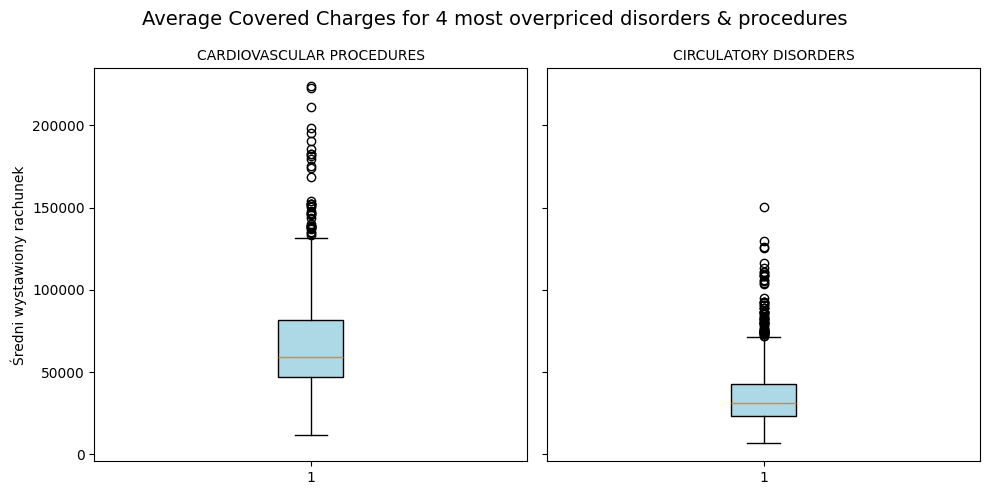

In [138]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

ax1.boxplot(wartosci_do_wykresu1, patch_artist=True, boxprops=dict(facecolor='lightblue'))
ax1.set_title('CARDIOVASCULAR PROCEDURES', fontsize=10)
ax1.set_ylabel("Średni wystawiony rachunek")


ax2.boxplot(wartosci_do_wykresu2, patch_artist=True, boxprops=dict(facecolor='lightblue'))
ax2.set_title('CIRCULATORY DISORDERS', fontsize=10)

fig.suptitle('Average Covered Charges for 4 most overpriced disorders & procedures', fontsize=14)

plt.tight_layout()
plt.savefig('wykres_boxplot.png')
plt.show()

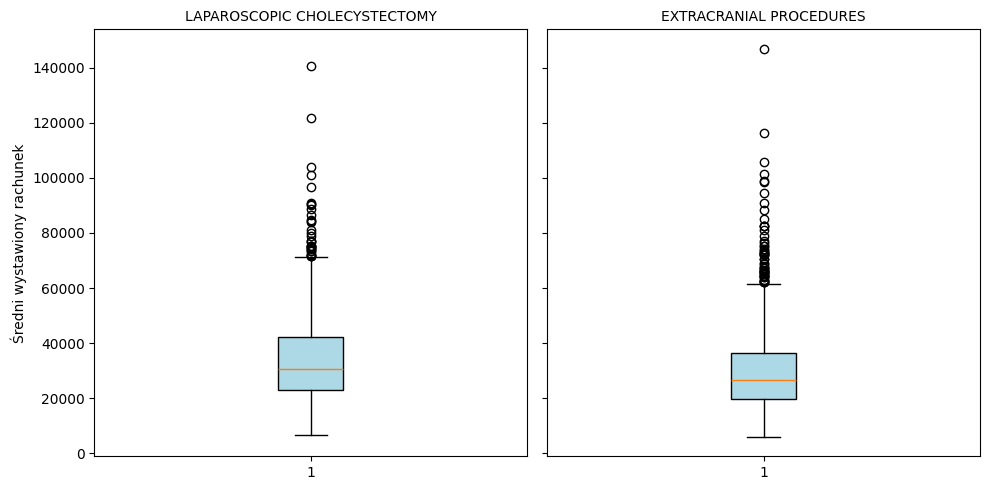

In [139]:
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)


ax3.boxplot(wartosci_do_wykresu3, patch_artist=True, boxprops=dict(facecolor='lightblue'))
ax3.set_title('LAPAROSCOPIC CHOLECYSTECTOMY', fontsize=10)
ax3.set_ylabel("Średni wystawiony rachunek")

ax4.boxplot(wartosci_do_wykresu4, patch_artist=True, boxprops=dict(facecolor='lightblue'))
ax4.set_title('EXTRACRANIAL PROCEDURES', fontsize=10)

plt.tight_layout()
plt.savefig('wykres_boxplot2.png')
plt.show()

In [140]:
print(choroba7['Medicare Payments2'].mean())

KeyError: 'Medicare Payments2'

In [ ]:
#Przekształcenie danych; utworzenie czterech osobnych zbiorów danych dla każdej z chorób
choroba5['Medicare Payments2'] = choroba5['Average Medicare Payments'] / choroba5[' Average Covered Charges ']
choroba5['Patient2'] = (choroba5[' Average Total Payments '] - choroba5['Average Medicare Payments'])/ choroba5[' Average Covered Charges ']
choroba5['Uncovered'] = 1 - choroba5['Medicare Payments2'] - choroba5['Patient2']

choroba6['Medicare Payments2'] = choroba6['Average Medicare Payments'] / choroba6[' Average Covered Charges ']
choroba6['Patient2'] = (choroba6[' Average Total Payments '] - choroba6['Average Medicare Payments'])/ choroba6[' Average Covered Charges ']
choroba6['Uncovered'] = 1 - choroba6['Medicare Payments2'] - choroba6['Patient2']

choroba7['Medicare Payments2'] = choroba7['Average Medicare Payments'] / choroba7[' Average Covered Charges ']
choroba7['Patient2'] = (choroba7[' Average Total Payments '] - choroba7['Average Medicare Payments'])/ choroba7[' Average Covered Charges ']
choroba7['Uncovered'] = 1 - choroba7['Medicare Payments2'] - choroba7['Patient2']

choroba8['Medicare Payments2'] = choroba8['Average Medicare Payments'] / choroba8[' Average Covered Charges ']
choroba8['Patient2'] = (choroba8[' Average Total Payments '] - choroba8['Average Medicare Payments'])/ choroba8[' Average Covered Charges ']
choroba8['Uncovered'] = 1 - choroba8['Medicare Payments2'] - choroba8['Patient2']

values1 = [
    choroba5['Uncovered'].mean(),
    choroba5['Patient2'].mean(),
    choroba5['Medicare Payments2'].mean()
]
values2 = [
    choroba6['Uncovered'].mean(),
    choroba6['Patient2'].mean(),
    choroba6['Medicare Payments2'].mean()
]
values3 = [
    choroba7['Uncovered'].mean(),
    choroba7['Patient2'].mean(), 
    choroba7['Medicare Payments2'].mean()
]
values4 = [
    choroba8['Uncovered'].mean(),
    choroba8['Patient2'].mean(),
    choroba8['Medicare Payments2'].mean()
]

labels = [
    'Uncovered',
    'Patient',
    'Medicare'
]

In [ ]:
print(choroba6['Patient2'].mean())

0.04800134033210757


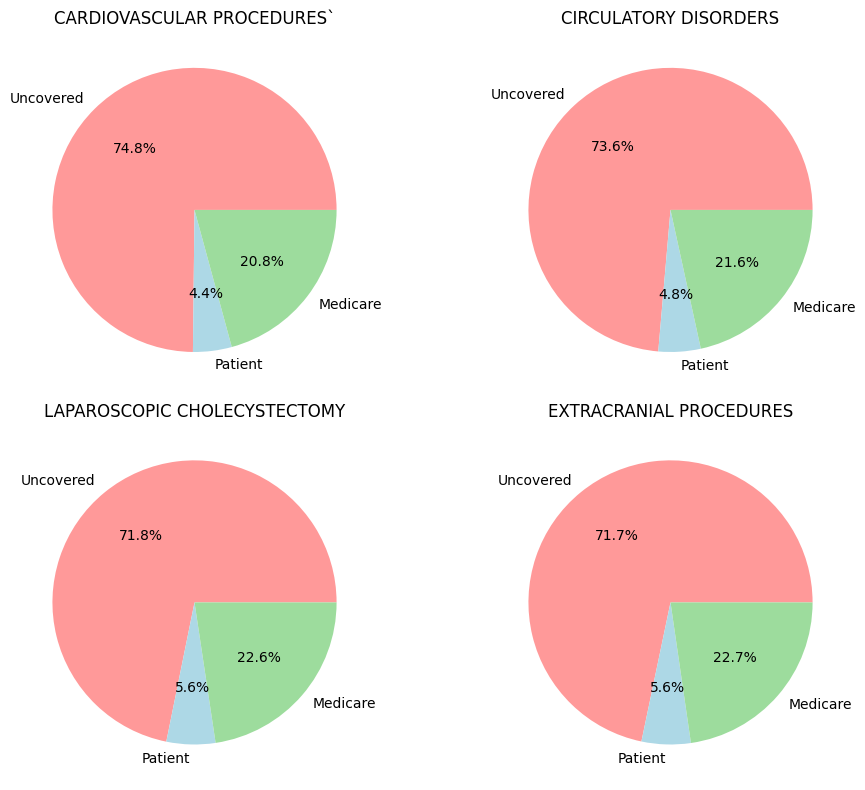

In [ ]:
#Stworzenie wykresów kołowych (przy pomocy AI)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

colors = ['#ff9999', 'lightblue', "#9ddc9d"]

axs[0, 0].pie(values1, colors = colors, labels=labels, autopct='%1.1f%%')
axs[0, 0].set_title('CARDIOVASCULAR PROCEDURES`')

axs[0, 1].pie(values2, colors = colors, labels=labels, autopct='%1.1f%%')
axs[0, 1].set_title('CIRCULATORY DISORDERS')

axs[1, 0].pie(values3, colors = colors, labels=labels, autopct='%1.1f%%')
axs[1, 0].set_title('LAPAROSCOPIC CHOLECYSTECTOMY')

axs[1, 1].pie(values4, colors = colors, labels=labels, autopct='%1.1f%%')
axs[1, 1].set_title('EXTRACRANIAL PROCEDURES')

plt.tight_layout()
plt.savefig('wykres_kolowy.png')
plt.show()
